### Preamble

In [1]:
# Import packages:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from pandas_datareader import data as pdr     
import yfinance as yf
import seaborn as sns
import warnings

# Import custom functions:
from aux_functions import *
from CallReports import CallReports
from mappings import mappings

# ignore warnings:
warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)

# Set the theme for plots
sns.set_theme(
    style   ="whitegrid",   # light grid behind the bars
    palette ="pastel"       # soft default colours
)
# Set serif font for plots
plt.rcParams['font.family'] = 'serif'

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'

In [3]:
# Import information on IDRSSD and Charter Type:
att_closed = pd.read_csv(f'{path}/CSV_ATTRIBUTES_CLOSED.csv', low_memory=False)
att_active = pd.read_csv(f'{path}/CSV_ATTRIBUTES_ACTIVE.csv', low_memory=False)

att_active.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_active = att_active[['IDRSSD', 'Charter Type']]

att_closed.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_closed = att_closed[['IDRSSD', 'Charter Type']]

# merge att_closed and att_active:
att = pd.concat([att_closed, att_active])

# Keep only commercial banks:
commercial_banks = att[att['Charter Type']==200]['IDRSSD'].unique()


In [4]:
# load DFF.csv file:
rates = pd.read_csv(f'{path}/DFF.csv', low_memory=False)
rates.rename(columns={'observation_date': 'Date', 'DFF':'FedFunds Rate'}, inplace=True)

# Convert 'Date' to datetime format:
rates['Date'] = pd.to_datetime(rates['Date'], format='%Y-%m-%d')
rates['Date'] = rates['Date'] - pd.Timedelta(days=1)
rates['FedFunds Rate'] = rates['FedFunds Rate']/100

In [5]:
cr = CallReports(path)

In [6]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
             'Date', 'IDRSSD', 'Financial Institution Name',            # Identifier Variables
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                     # Total Assets
            'RCON3368', 'RCFD3368',                                     # QA Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                    # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',                                                # Total Deposits
             'RCON2215',                                                # Transaction Deposits
             'RCON6648',                                                # 0-100k
             'RCON2604',                                                # 100k+ (old)
             'RCONJ473',                                                # 100-250k (new)
             'RCONJ474',                                                # 250k+ (new)
             # ------------------------------------------------------------------------------------------------
             'RCONF045', 'RCONF046', 'RCONF047', 
             'RCONF048', 'RCONF049', 'RCONF050',
             'RCONF051', 'RCONF052', 'RCON3645',                        # Uninsured Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON3210', 'RCFD3210',                                    # Total Equity Capital
             'RCONB530', 'RCFDB530',                                    # AOCI
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1771', 'RCFD1771',                                    # HTM Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON1772', 'RCFD1772',                                    # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCONJJ34', 'RCFDJJ34',                                    
             'RCONJA22', 'RCFDJA22',                                    # Booked Securities
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCONB987',                                                # FF sold in domestic offices
             'RCONB989', 'RCFDB989',                                    # Resell agreements                                  
             # ------------------------------------------------------------------------------------------------
             'RCFD0081', 'RCON0081',                                    # Cash and Balances Due from Depository Institutions
             'RCFD0071', 'RCON0071',
             'RCFD0010', 'RCON0010',
             # ------------------------------------------------------------------------------------------------
             'RIAD4508',                                                 # Interest Expenses
             'RIADA517', 'RIADA518', 'RIAD0093',
             'RIADHK03', 'RIADHK04', 'RIAD4073', 'RIAD4200', 'RIAD4185', 
             'RIAD4180', 'RIAD4172', 'RIAD4107', 'RIAD4340', 'RIAD4093'
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [7]:
main = cr.select_variables(all_vars)

Duplicate variable RCFD1754: max gap between RCFD1754_x and RCFD1754_y is 0.0
Dropping duplicate column RCFD1754_y as it is identical to RCFD1754_x.
Duplicate variable RCFD1773: max gap between RCFD1773_x and RCFD1773_y is 0.0
Dropping duplicate column RCFD1773_y as it is identical to RCFD1773_x.
Duplicate variable RCON1754: max gap between RCON1754_x and RCON1754_y is 0.0
Dropping duplicate column RCON1754_y as it is identical to RCON1754_x.


In [8]:
# Create all the new variables:
main = cr.construct_definitions(mappings=mappings)

c:\Users\angel\Documents\Economics\Research\Banking Project\Banking_projects\codes\CallReports.py:267: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return df_slice[col2].combine_first(df_slice[col1])
c:\Users\angel\Documents\Economics\Research\Banking Project\Banking_projects\codes\CallReports.py:267: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return df_slice[col2].combine_first(df_slice[col1])
c:\Users\angel\Documents\Economics\Research\Banking Project\Banking_projects\codes\CallReports.py:267: FutureWarning: The behavior of array concatenation with

In [9]:
# keep only commercial banks:
main = main[main['IDRSSD'].isin(commercial_banks)]

In [10]:
# merge main with rates per 'Date':
main = pd.merge(main, rates, on='Date', how='left')

In [11]:
# Create 'Insured Deposit Accounts' and 'Number of Insured Deposit Accounts'
main['Insured Deposit Accounts'] = main['RCONF045'] + main['RCONF049']
main['Number of Insured Deposit Accounts'] = main['RCONF046'] + main['RCONF050']

# Create 'Uninsured Deposit Accounts' and 'Number of Uninsured Deposit Accounts'
main['Uninsured Deposit Accounts'] = main['RCONF047'] + main['RCONF051']
main['Number of Uninsured Deposit Accounts'] = main['RCONF048'] + main['RCONF052']

# Correct insurance coverage threshold based on date:
main['Insurance Coverage'] = np.where(main['Date'] < pd.Timestamp('2010-03-01'), 100, 250)

# Recalculate 'Insured Deposits' considering coverage threshold:
main['Insured Deposits'] = (
    main['Insured Deposit Accounts'] +
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Recalculate 'Uninsured Deposits':
main['Uninsured Deposits'] = (
    main['Uninsured Deposit Accounts'] -
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Create 'Total Deposits 2':
main['Total Deposits 2'] = main['Insured Deposits'] + main['Uninsured Deposits']

In [12]:
# Recompute 'Time Deposits Expenses' considering that it accumulates over 'Year'. We want expenses per 'Date'. Use 
# groupby(['IDRSSD, 'Year']):
main['Time Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Time Deposit Expenses']
    .diff().fillna(main['Time Deposit Expenses'])
)

# Do the same for 'Transaction Deposit Expenses':
main['Transaction Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Transaction Deposit Expenses']
    .diff().fillna(main['Transaction Deposit Expenses'])
)

# Do the same for 'Savings Expenses':
main['Savings Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Savings Expenses']
    .diff().fillna(main['Savings Expenses'])
)

# Do the same for 'Interest Expenses on Subordinated Debt':
main['Interest Expenses on Subordinated Debt'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Subordinated Debt']
    .diff().fillna(main['Interest Expenses on Subordinated Debt'])
)

# Do the same for 'Interest Expenses on FFS':
main['Interest Expenses on FFS'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on FFS']
    .diff().fillna(main['Interest Expenses on FFS'])
)

# Do the same for 'Interest Expenses on Foreign Deposits':
main['Interest Expenses on Foreign Deposits'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Foreign Deposits']
    .diff().fillna(main['Interest Expenses on Foreign Deposits'])
)

# Do the same for 'Total Interest Expenses':
main['Total Interest Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Expenses']
    .diff().fillna(main['Total Interest Expenses'])
)

# Do the same for 'Total Interest Income':
main['Total Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Income']
    .diff().fillna(main['Total Interest Income'])
)

# Do the same for 'Net Interest Income':
main['Net Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Net Interest Income']
    .diff().fillna(main['Net Interest Income'])
)

# Create 'Deposit Expenses' as the sum of all deposit expenses:
main['Deposit Expenses'] = (
    main['Transaction Deposit Expenses'] +
    main['Savings Expenses'] +
    main['Time Deposit Expenses']
)

# Compute 'Deposit Expenses 2':
main['Deposit Expenses 2'] = (
    main['Total Interest Expenses'].fillna(0) - main['Interest Expenses on Subordinated Debt'].fillna(0) - 
    main['Other Interest Expenses'].fillna(0) - main['Interest Expenses on FFS'].fillna(0) - 
    main['Interest Expenses on Foreign Deposits'].fillna(0)
)

main['Non Interest Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Non Interest Expenses']
    .diff().fillna(main['Non Interest Expenses'])
)

In [13]:
# create 'Deposit Rates' as the ratio of 'Deposit Expenses' to 'Total Deposits':
main['Deposit Rates'] = main['Deposit Expenses'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates'] = main['Deposit Rates'].mask(main['Deposit Rates'] <= 0, np.nan)

main['Deposit Rates 2'] = main['Deposit Expenses 2'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates 2'] = main['Deposit Rates 2'].mask(main['Deposit Rates 2'] <= 0, np.nan)

In [14]:
# Create the new variables:
main['Total Securities'] = main['HTM Securities'].fillna(0) + main['AFS Securities'].fillna(0) + main['Equity Securities'].fillna(0)
main['Securities per Assets'] = main['Total Securities'] / main['Total Assets']
main['Securities and FFS per Asset'] = (main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash, Securities and FFS per Asset'] = (main['Cash'] + main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash per Asset'] = main['Cash'] / main['Total Assets']
# mask shares that are negative or greater than 1:
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] < 0, np.nan)
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] > 1, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] < 0, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] > 1, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] < 0, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] > 1, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] < 0, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] > 1, np.nan)

# Create 'Interest Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives
main['Interest Expenses Rate'] = 4* main['Total Interest Expenses'] / main['QA Total Assets']
main['Interest Expenses Rate'] = main['Interest Expenses Rate'].mask(main['Interest Expenses Rate'] < 0, np.nan)

# Create 'Interest Income Rate' as the ratio of income and Total Assets, mask the negatives:
main['Interest Income Rate'] = 4* main['Total Interest Income'] / main['QA Total Assets']
main['Interest Income Rate'] = main['Interest Income Rate'].mask(main['Interest Income Rate'] < 0, np.nan)

# Create 'Deposit Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives:
main['Deposit Expenses Rate'] = 4* main['Deposit Expenses 2'] / main['QA Total Assets']
main['Deposit Expenses Rate'] = main['Deposit Expenses Rate'].mask(main['Deposit Expenses Rate'] < 0, np.nan)

# Create 'Non Interest Expenses Rate' as the ratio of Non Interest Expenses and Total Assets, mask the negatives:
main['Non Interest Expenses Rate'] = 4* main['Non Interest Expenses'] / main['QA Total Assets']
main['Non Interest Expenses Rate'] = main['Non Interest Expenses Rate'].mask(main['Non Interest Expenses Rate'] < 0, np.nan)

# Create 'Return on Assets' as the ratio of Net Interest Income and Total Assets, mask the negatives:
main['Return on Assets'] = 4* main['Net Interest Income'] / main['QA Total Assets']
main['Return on Assets'] = main['Return on Assets'].mask(main['Return on Assets'] < 0, np.nan)

# Create 'NIM' as the difference between 'Interest Income Rate' and 'Interest Expenses Rate':
main['NIM'] = main['Interest Income Rate'] - main['Interest Expenses Rate']

# Create 'Leverage Ratio' as the ratio of Total Assets and Total Equity Capital:
main['Leverage Ratio'] = main['Total Assets'] / main['Total Equity Capital']
main['Leverage Ratio'] = main['Leverage Ratio'].mask(main['Leverage Ratio'] < 0, np.nan)

### Zooming in the top percentile. 

In [15]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Securities', 'Deposit Rates', 'Total Deposits', 'AOCI',
           'Securities per Assets', 'Securities and FFS per Asset', 'Cash, Securities and FFS per Asset', 'Leverage Ratio',
           'Total Assets', 'HTM Securities', 'AFS Securities', 'FFS', 'Equity Securities', 'Cash', 'Securities FV', 'Securities AC',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses', 
           'Deposit Expenses Rate', 'FedFunds Rate', 'Return on Assets', 'NIM', 'Interest Income Rate', 
           'Non Interest Expenses', 'Treasuries (3M-)', 'Treasuries (3M-1Y)', 'Treasuries (1Y-3Y)',
           'Treasuries (3Y-5Y)', 'Treasuries (5Y-15Y)', 'Treasuries (15Y+)',]]

In [16]:
# --- per-Date moments -------------------------------------------------
grp = df.groupby('Date')

df['rbar'] = grp['Deposit Rates'].transform('mean')      # mean r
df['sd_r'] = grp['Deposit Rates'].transform('std')       # sd   r
df['qbar'] = grp['Total Deposits'].transform('mean')   # mean q
df['sd_q'] = grp['Total Deposits'].transform('std')    # sd   q

# --- scaled (z-score) versions ---------------------------------------
df['rhat'] = np.where(
    df['sd_r'] != 0,
    (df['Deposit Rates'] - df['rbar']) / df['sd_r'],
    np.nan
)
df['qhat'] = np.where(
    df['sd_q'] != 0,
    (df['Total Deposits'] - df['qbar']) / df['sd_q'],
    np.nan
)

# --- demeaned versions -----------------------------------------------
df['rtilde'] = df['Deposit Rates']     - df['rbar']
df['qtilde'] = df['Total Deposits']  - df['qbar']

# optional: keep only the scaled rate under a clearer name
df.rename(columns={'rhat': 'Scaled Deposit Rates'}, inplace=True)

In [17]:
df['Log Total Assets'] = np.log(df['Total Assets'])

In [18]:
# Create a subset keeping only banks in the top 1% of Total Assets per Date
df_top1 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.quantile(0.99))]

# Do the same, for the top 10, 20, and 50 nlargest banks per Date in Total Assets:
df_top5 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(5).min())]
df_top10 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(10).min())]
df_top20 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(20).min())]
df_top50 = df[df.groupby('Date')['Total Assets'].transform(lambda x: x >= x.nlargest(50).min())]

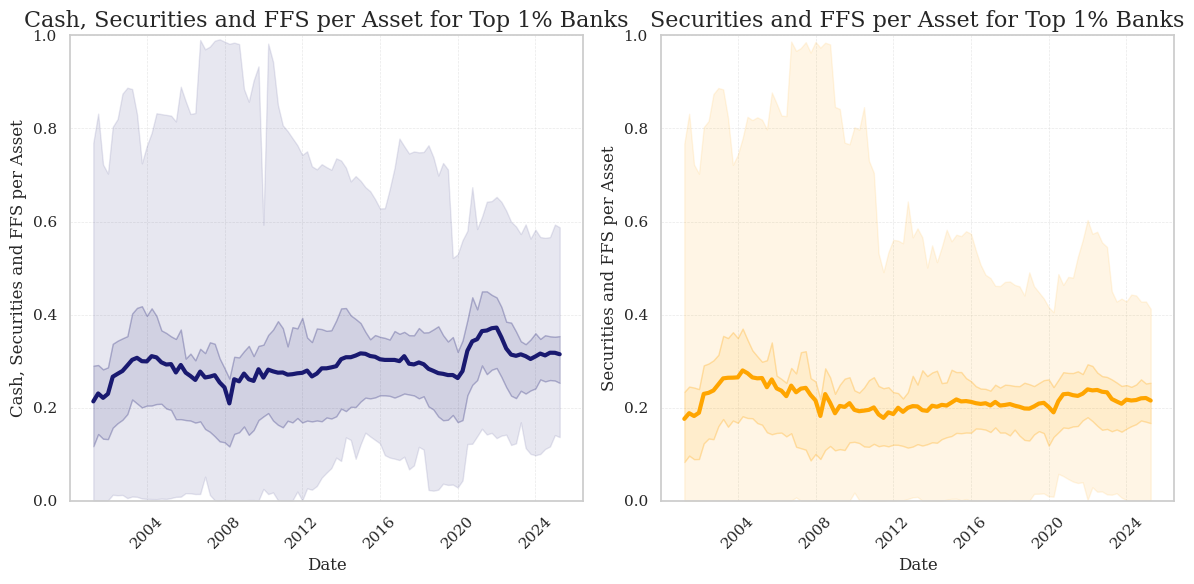

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Top 1% Banks
# Left panel – include extra lines for SVB and First Republic
plot_with_range(ax1, df_top1, 'Cash, Securities and FFS per Asset', 'midnightblue')
ax1.set_title('Cash, Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylim(0, 1)

plot_with_range(ax2, df_top1, 'Securities and FFS per Asset', 'orange')
ax2.set_title('Securities and FFS per Asset for Top 1% Banks', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

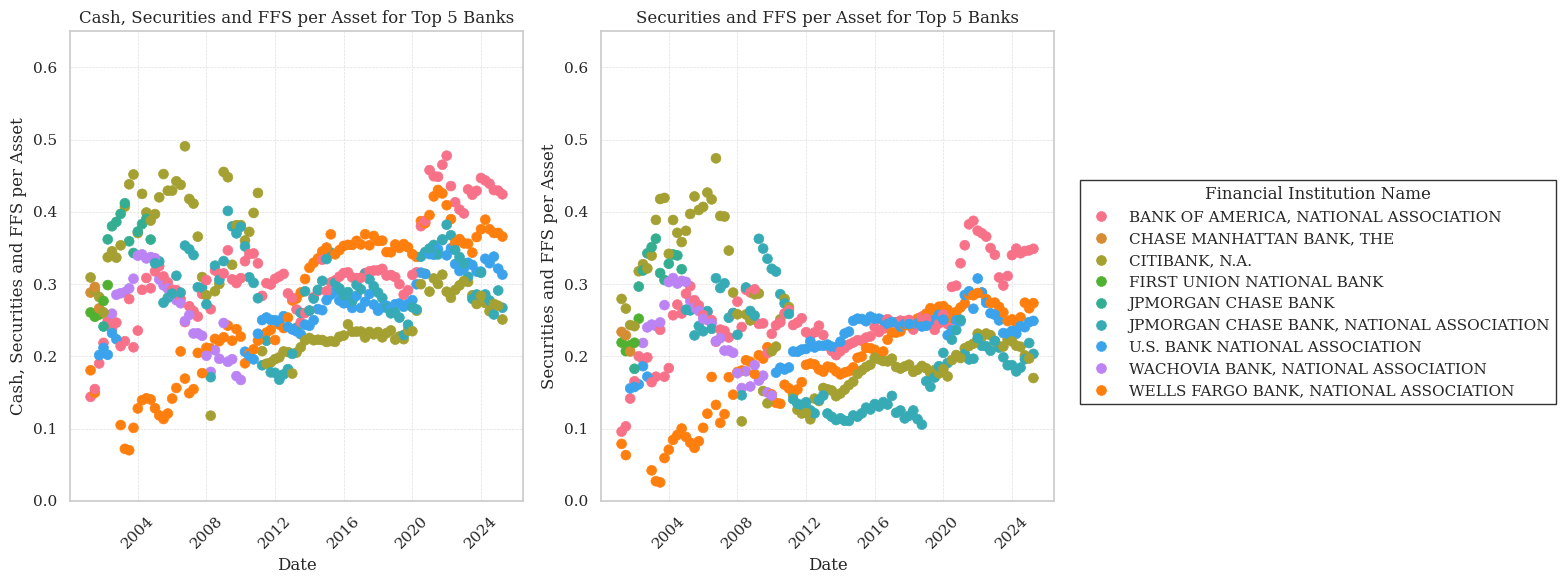

In [20]:
# -----------------------------------------------------------------
# 1) Build a *stable* ordering of banks
# -----------------------------------------------------------------
hue_order = sorted(df_top5["Financial Institution Name"].unique())

# -----------------------------------------------------------------
# 2) Create a palette with one unique colour per bank
#       – `husl` spreads hues evenly around the colour wheel
#       – works for *any* number of categories (n can be > 20)
# -----------------------------------------------------------------
palette = sns.color_palette("husl", n_colors=len(hue_order))

# OPTIONAL: if you want to *force* certain colours for specific banks
#           (e.g. corporate branding), override them in a dict:
custom_palette = dict(zip(hue_order, palette))
custom_palette.update({
     "WELLS FARGO BANK, NATIONAL ASSOCIATION":     "#ff7f0e",   # vivid orange
     "BANK ONE, NATIONAL ASSOCIATION":               "black",   # vivid blue
 })
palette = custom_palette            # use this instead

# -----------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ---------- Left panel -------------------------------------------
sns.scatterplot(
    data=df_top5,
    x="Date",
    y="Cash, Securities and FFS per Asset",
    hue="Financial Institution Name",
    hue_order=hue_order,
    palette=palette,          # <-- NEW PALETTE
    ax=ax1,
    s=50, edgecolor=None, linewidth=0.5,
    legend="full"             # build local legend once
)

ax1.set_ylim(0, 0.65)
ax1.set_title("Cash, Securities and FFS per Asset for Top 5 Banks")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cash, Securities and FFS per Asset")
ax1.grid(True, linestyle="--", alpha=0.7, linewidth=0.5, color="lightgray")
ax1.tick_params(axis="x", rotation=45)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend_.remove()

# ---------- Right panel ------------------------------------------
sns.scatterplot(
    data=df_top5,
    x="Date",
    y="Securities and FFS per Asset",
    hue="Financial Institution Name",
    hue_order=hue_order,
    palette=palette,          # <-- SAME PALETTE -> consistent colours
    ax=ax2,
    s=50, edgecolor=None, linewidth=0.5,
    legend=False
)

ax2.set_ylim(0, 0.65)
ax2.set_title("Securities and FFS per Asset for Top 5 Banks")
ax2.set_xlabel("Date")
ax2.set_ylabel("Securities and FFS per Asset")
ax2.grid(True, linestyle="--", alpha=0.7, linewidth=0.5, color="lightgray")
ax2.tick_params(axis="x", rotation=45)


# ---------- Shared legend (closer to plots) ----------------------
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(0.9, 0.5),   # adjust till it looks right
    ncol=1,
    frameon=True, fancybox=False, edgecolor="black",
    title="Financial Institution Name",
    fontsize=11
)

fig.tight_layout(rect=[0, 0, 0.9, 1])   # reserve 10 % width for legend
plt.show()

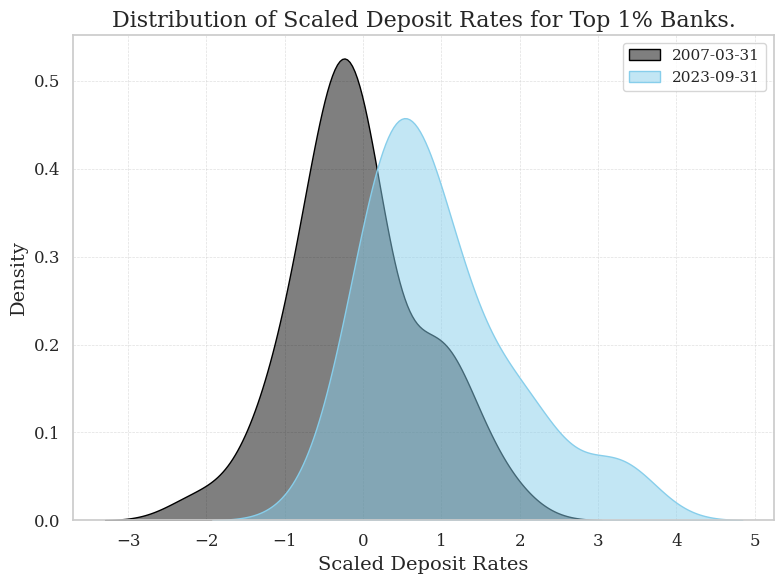

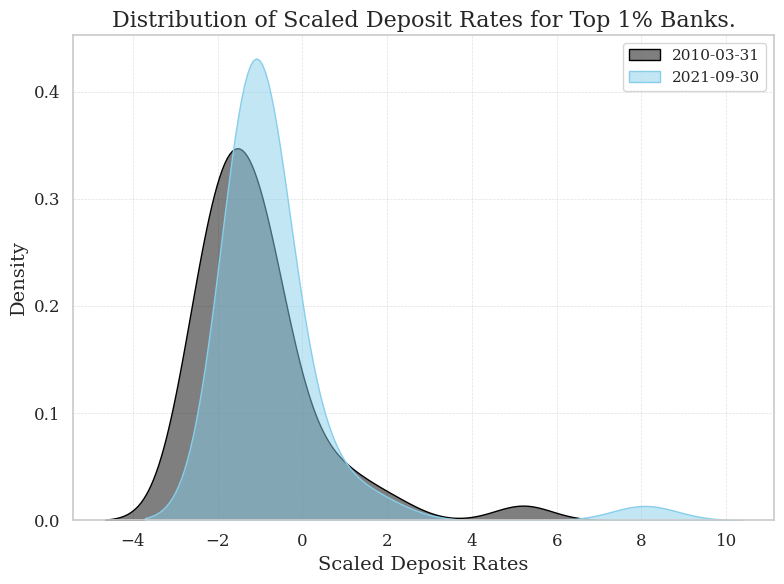

In [21]:
# make a histogram of 'Scaled Deposit Rates' for the top 1% of banks for 2007-03-31:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=df_top1[df_top1['Date'] == '2007-03-31'],
    x='Scaled Deposit Rates',
    color='black',
    fill=True,
    alpha=0.5
)
sns.kdeplot(
    data=df_top1[df_top1['Date'] == '2023-09-30'],
    x='Scaled Deposit Rates',
    color='skyblue',
    fill=True,
    alpha=0.5
)
plt.title('Distribution of Scaled Deposit Rates for Top 1% Banks.', fontsize=16)
plt.xlabel('Scaled Deposit Rates', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['2007-03-31', '2023-09-31'])
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# Do the same for 2010-03-31 and 2015-06-30:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=df_top1[df_top1['Date'] == '2010-03-31'],
    x='Scaled Deposit Rates',
    color='black',
    fill=True,
    alpha=0.5
)
sns.kdeplot(
    data=df_top1[df_top1['Date'] == '2021-09-30'],
    x='Scaled Deposit Rates',
    color='skyblue',
    fill=True,
    alpha=0.5
)
plt.title('Distribution of Scaled Deposit Rates for Top 1% Banks.', fontsize=16)
plt.xlabel('Scaled Deposit Rates', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['2010-03-31', '2021-09-30'])
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

,Number of Banks in Histogram
2007-03-31,44
2023-09-30,39
2010-03-31,43
2021-09-30,40


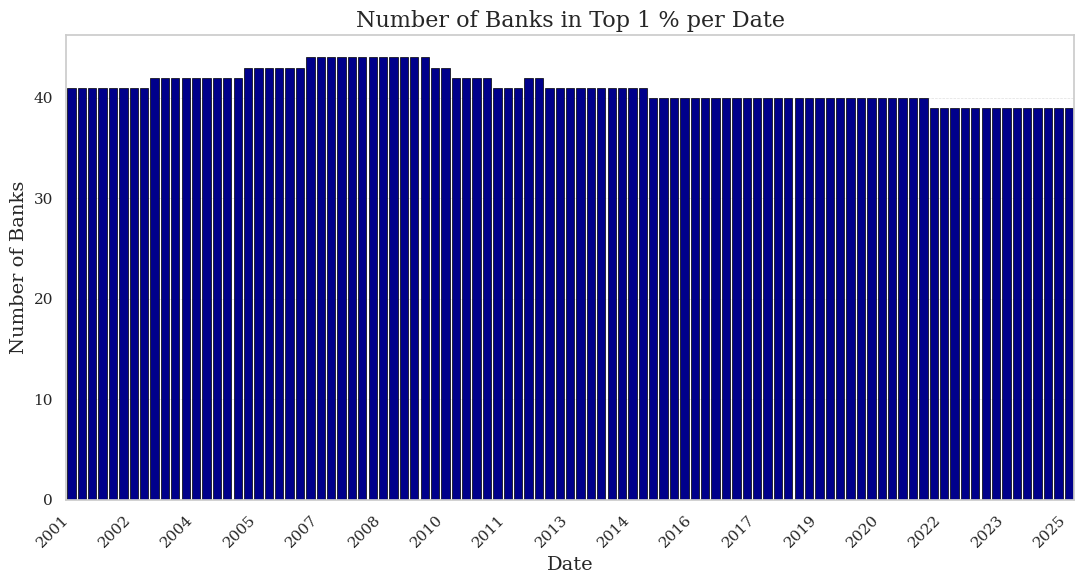

In [22]:
# make a table telling how many banks are plotted in each histogram above:
hist_counts = {
    '2007-03-31': df_top1[df_top1['Date'] == '2007-03-31'].shape[0],
    '2023-09-30': df_top1[df_top1['Date'] == '2023-09-30'].shape[0],
    '2010-03-31': df_top1[df_top1['Date'] == '2010-03-31'].shape[0],
    '2021-09-30': df_top1[df_top1['Date'] == '2021-09-30'].shape[0]
}
hist_counts_df = pd.DataFrame.from_dict(hist_counts, orient='index', columns=['Number of Banks in Histogram'])
display(hist_counts_df)

df_top1 = df_top1.sort_values('Date')

# aggregate   (one bar per reporting date)
count_by_date = df_top1.groupby('Date').size().reset_index(name='n_banks')

# --- plot --------------------------------------------------------------------
plt.figure(figsize=(11, 6))
ax = sns.barplot(data=count_by_date, x='Date', 
                 y='n_banks', color='darkblue', edgecolor='black', 
                 linewidth=0.5, saturation=1, width=0.8)

ax.set_title('Number of Banks in Top 1 % per Date', fontsize=16)
ax.set_ylabel('Number of Banks', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

# choose how many labels you want:
#   every quarter -> mdates.MonthLocator(bymonth=[1,4,7,10])
#   every second quarter -> mdates.MonthLocator(bymonth=[1,7])
#   every year  -> mdates.YearLocator()
# or, for one label every *n* bars (no dates involved):
k = 6                               # one label every 6 bars
pos = range(0, len(count_by_date), k)
ax.set_xticks(pos)
ax.set_xticklabels(count_by_date['Date'].dt.strftime('%Y').iloc[pos])
# add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


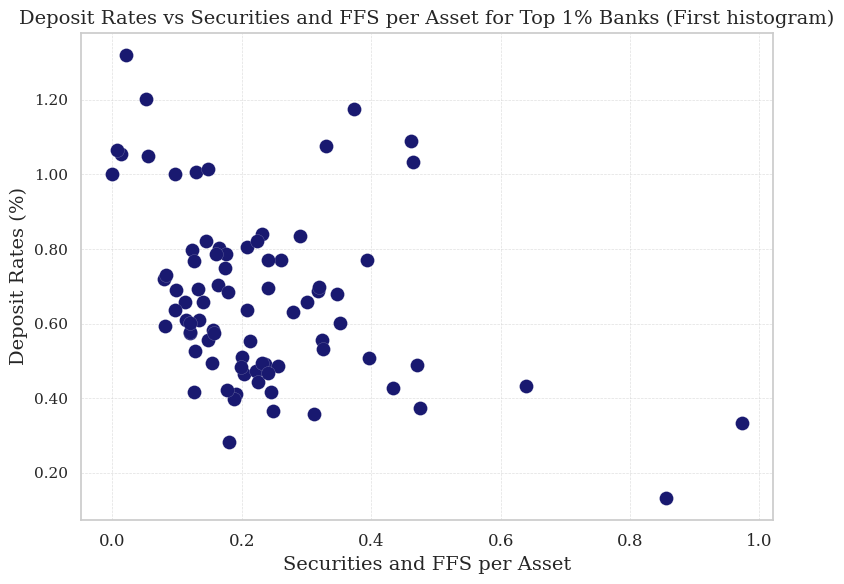

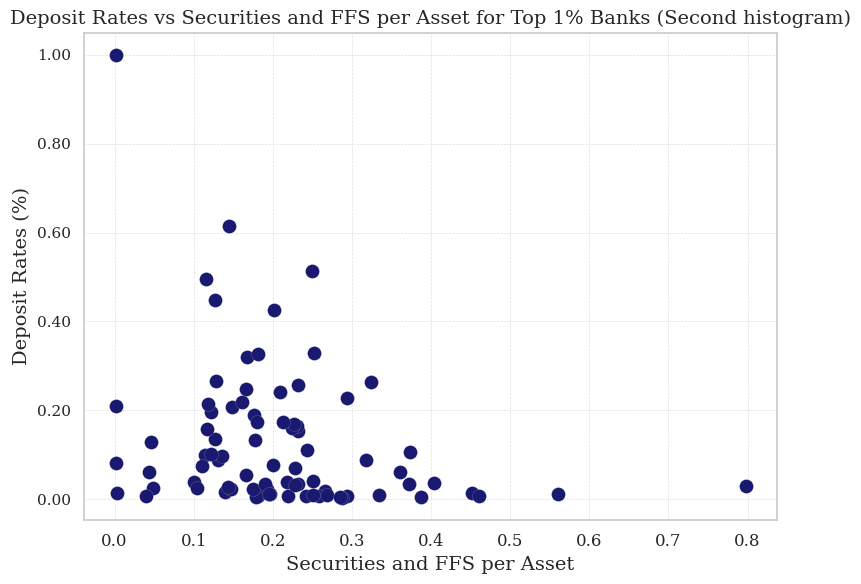

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_top1[(df_top1['Date'] == '2023-09-30') | (df_top1['Date'] == '2007-03-31')],
    x='Securities and FFS per Asset',
    y='Deposit Rates',
    s=100, edgecolor='white', linewidth=0.1,
    color='midnightblue', alpha=1, marker='o'
)
plt.title('Deposit Rates vs Securities and FFS per Asset for Top 1% Banks (First histogram)', fontsize=14)
plt.xlabel('Securities and FFS per Asset', fontsize=14)
plt.ylabel('Deposit Rates (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(fontsize=12)

# Multiply y-axis tick labels by 100 
formatter = FuncFormatter(lambda x, pos: f'{x*100:.2f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_top1[(df_top1['Date'] == '2010-03-31') | (df_top1['Date'] == '2021-09-30')],
    x='Securities and FFS per Asset',
    y='Deposit Rates',
    s=100, edgecolor='white', linewidth=0.1,
    color='midnightblue', alpha=1, marker='o'
)
plt.title('Deposit Rates vs Securities and FFS per Asset for Top 1% Banks (Second histogram)', fontsize=14)
plt.xlabel('Securities and FFS per Asset', fontsize=14)
plt.ylabel('Deposit Rates (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(fontsize=12)

# Multiply y-axis tick labels by 100 
formatter = FuncFormatter(lambda x, pos: f'{x*100:.2f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

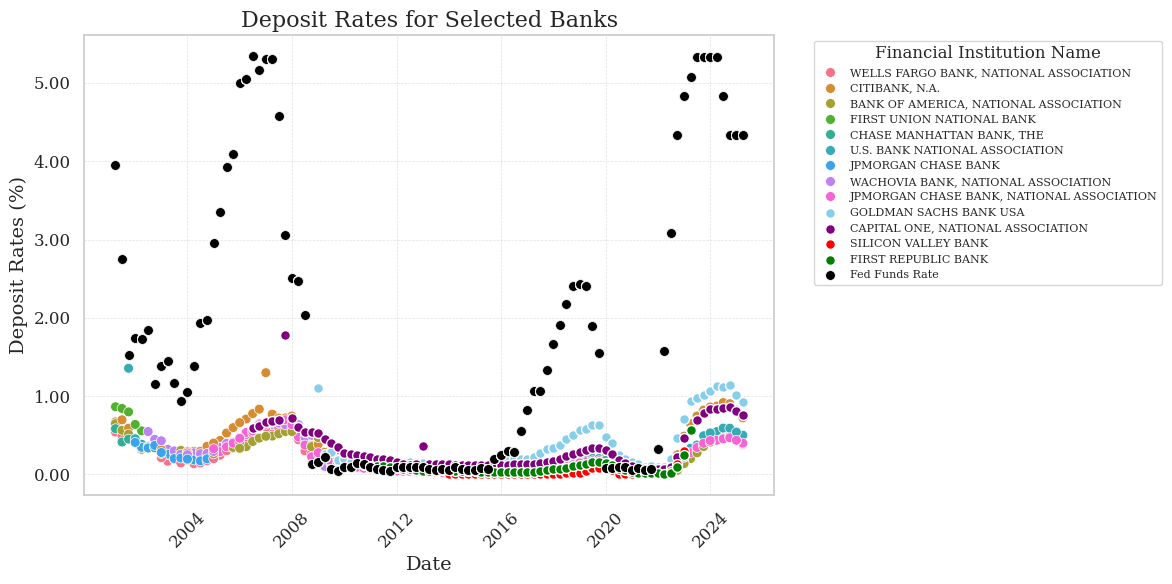

In [24]:
# use seaborn to make a scatter plot of 'Deposit Rates' using df_top5. Use the 'Financial Institution Name' as hue and the 'Date' as x-axis.
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_top5,
    x='Date',
    y='Deposit Rates',
    hue='Financial Institution Name',
    palette='husl',  # use the same palette as before
    s=50, edgecolor='white', linewidth=0.5
)
# Add the GOLDMAN SACHS BANK USA:
sns.scatterplot(
    data=df_top1[df_top1['Financial Institution Name'] == 'GOLDMAN SACHS BANK USA'],
    x='Date',
    y='Deposit Rates',
    color='skyblue',
    s=50, edgecolor='white', linewidth=1, label='GOLDMAN SACHS BANK USA'
)
# Add 'CAPITAL ONE, NATIONAL ASSOCIATION':
sns.scatterplot(
    data=df_top1[df_top1['Financial Institution Name'] == 'CAPITAL ONE, NATIONAL ASSOCIATION'],
    x='Date',
    y='Deposit Rates',
    color='purple',
    s=50, edgecolor='white', linewidth=1, label='CAPITAL ONE, NATIONAL ASSOCIATION'
)
# Add 'SILICON VALLEY BANK':
sns.scatterplot(
    data=df_top1[df_top1['Financial Institution Name'] == 'SILICON VALLEY BANK'],
    x='Date',
    y='Deposit Rates',
    color='red',
    s=50, edgecolor='white', linewidth=1, label='SILICON VALLEY BANK'
)
# add 'FIRST REPUBLIC BANK':
sns.scatterplot(
    data=df_top1[df_top1['Financial Institution Name'] == 'FIRST REPUBLIC BANK'],
    x='Date',
    y='Deposit Rates',
    color='green',
    s=50, edgecolor='white', linewidth=1, label='FIRST REPUBLIC BANK'
)
sns.scatterplot(
    data=df_top1,
    x='Date',
    y='FedFunds Rate',
    color='black', s=50, label='Fed Funds Rate'
)


plt.title('Deposit Rates for Selected Banks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Deposit Rates (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-0.001, 0.015)  # set y-axis limit to [0, 0.05] for better visibility
# put legend outside the plot, to the right
plt.legend(title='Financial Institution Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
# Multiply y-axis tick labels by 100 
formatter = FuncFormatter(lambda x, pos: f'{x*100:.2f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

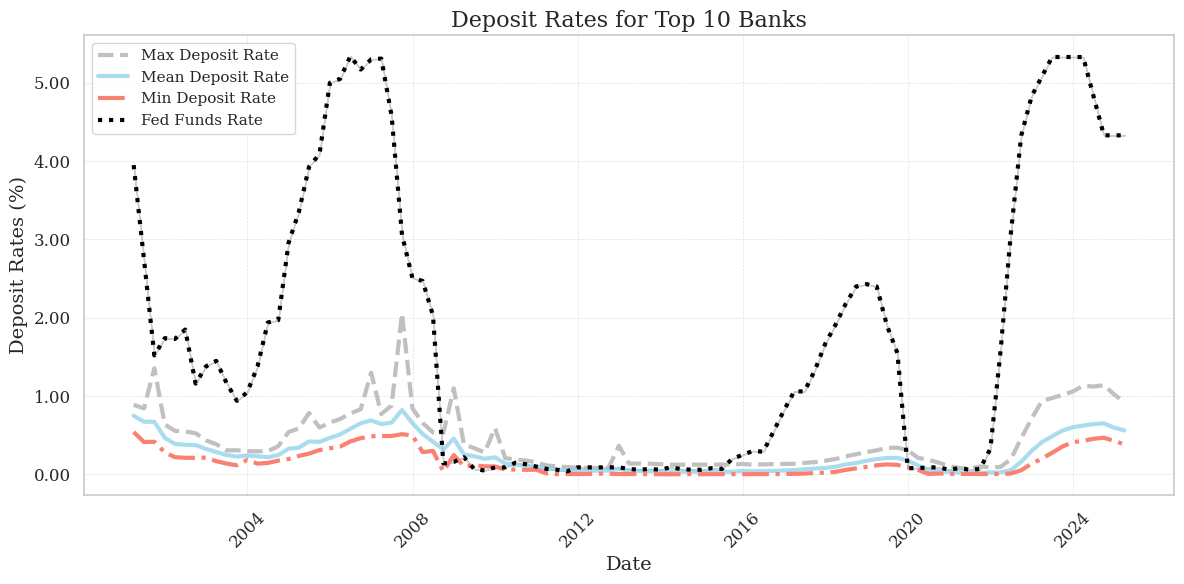

In [25]:
# for all banks in df_top1, plot the 'Deposit Rates' time series using seaborn:
plt.figure(figsize=(12, 6))
# add to the plot the 'max' deposit rates for the top 1% banks:
max_deposit_rate = df_top10.groupby('Date')['Deposit Rates'].max().reset_index()
sns.lineplot(
    data=max_deposit_rate,
    x='Date',
    y='Deposit Rates',
    color='silver', lw=3, ls='--', label='Max Deposit Rate'
)
sns.lineplot(
    data=df_top10,
    x='Date',
    y='Deposit Rates',
    color='skyblue',
    lw=3, alpha=0.7, errorbar=None, label='Mean Deposit Rate',
)
# add to the plot the 'min' deposit rates for the top 1% banks:
min_deposit_rate = df_top10.groupby('Date')['Deposit Rates'].min().reset_index()
sns.lineplot(
    data=min_deposit_rate,
    x='Date',
    y='Deposit Rates',
    color='salmon', lw=3, ls='-.', label='Min Deposit Rate'
)
sns.lineplot(
    data=df_top1,
    x='Date',
    y='FedFunds Rate',
    color='black', lw=3, ls=':', label='Fed Funds Rate'
)

plt.title('Deposit Rates for Top 10 Banks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Deposit Rates (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Multiply y-axis tick labels by 100
formatter = FuncFormatter(lambda x, pos: f'{x*100:.2f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### AOCI and MTM Losses

In [26]:
# Create a subset keeping only banks in the top 1% of Total Assets per Date
df_temp = df_top1.copy()

In [27]:
#final_date = pd.Timestamp('2023-01-01')
final_date = df_temp['Date'].max()

In [28]:
df_temp['Total Securities'] = df_temp['HTM Securities'].fillna(0) + df_temp['AFS Securities'].fillna(0) #+ df_temp['Equity Securities'].fillna(0)
df_temp['AOCI %'] = (df_temp['AOCI'] / df_temp['Total Assets']) * 100
# compute the difference between 'Securities Booked' and 'Securities FV':
df_temp['MTM Losses HTM'] = -(df_temp['Total Securities'] - df_temp['Securities FV'])
df_temp['MTM Losses %'] = 100*((df_temp['MTM Losses HTM']+df_temp['AOCI']) / df_temp['Total Assets'])

In [29]:
# Compute weighted average AOCI among other banks by total assets
weighted_avg_aoci = (
    df_temp[['Date', 'AOCI %', 'Total Assets']]
    .groupby('Date')
    .apply(lambda x: (x['AOCI %'] * x['Total Assets']).sum() / x['Total Assets'].sum())
    .sort_index()
    .reset_index(name='AOCI %')
)

# Compute simple average AOCI among other banks
simple_avg_aoci = (
    df_temp[['Date', 'AOCI %']]
    .groupby('Date')
    .mean()
    .sort_index()
    .reset_index()
)

C:\Users\angel\AppData\Local\Temp\ipykernel_21008\2564506794.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['AOCI %'] * x['Total Assets']).sum() / x['Total Assets'].sum())


In [30]:
weighted_avg_mtm = (
    df_temp[['Date', 'MTM Losses %', 'Total Assets']]
    .groupby('Date')
    .apply(lambda x: (x['MTM Losses %'] * x['Total Assets']).sum() / x['Total Assets'].sum())
    .sort_index()
    .reset_index(name='MTM Losses %')
)

# Compute simple average AOCI among other banks
simple_avg_mtm = (
    df_temp[['Date', 'MTM Losses %']]
    .groupby('Date')
    .mean()
    .sort_index()
    .reset_index()
)

C:\Users\angel\AppData\Local\Temp\ipykernel_21008\276478897.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['MTM Losses %'] * x['Total Assets']).sum() / x['Total Assets'].sum())


In [31]:
# aggregate the MTM losses by date and plot using df_temp['Date'] as x-axis:
mtm_agg = df_temp.groupby('Date')['MTM Losses HTM'].sum().reset_index().sort_values('Date')
# rename MTM Losses to MTM Losses HTM:
mtm_agg['MTM Losses AFS'] = df_temp.groupby('Date')['AOCI'].sum().reset_index().sort_values('Date')['AOCI']
# multiply by 1000 to convert to billions:
mtm_agg['MTM Losses HTM'] = mtm_agg['MTM Losses HTM'] * 1000 / 1e9
mtm_agg['MTM Losses AFS'] = mtm_agg['MTM Losses AFS'] * 1000 / 1e9


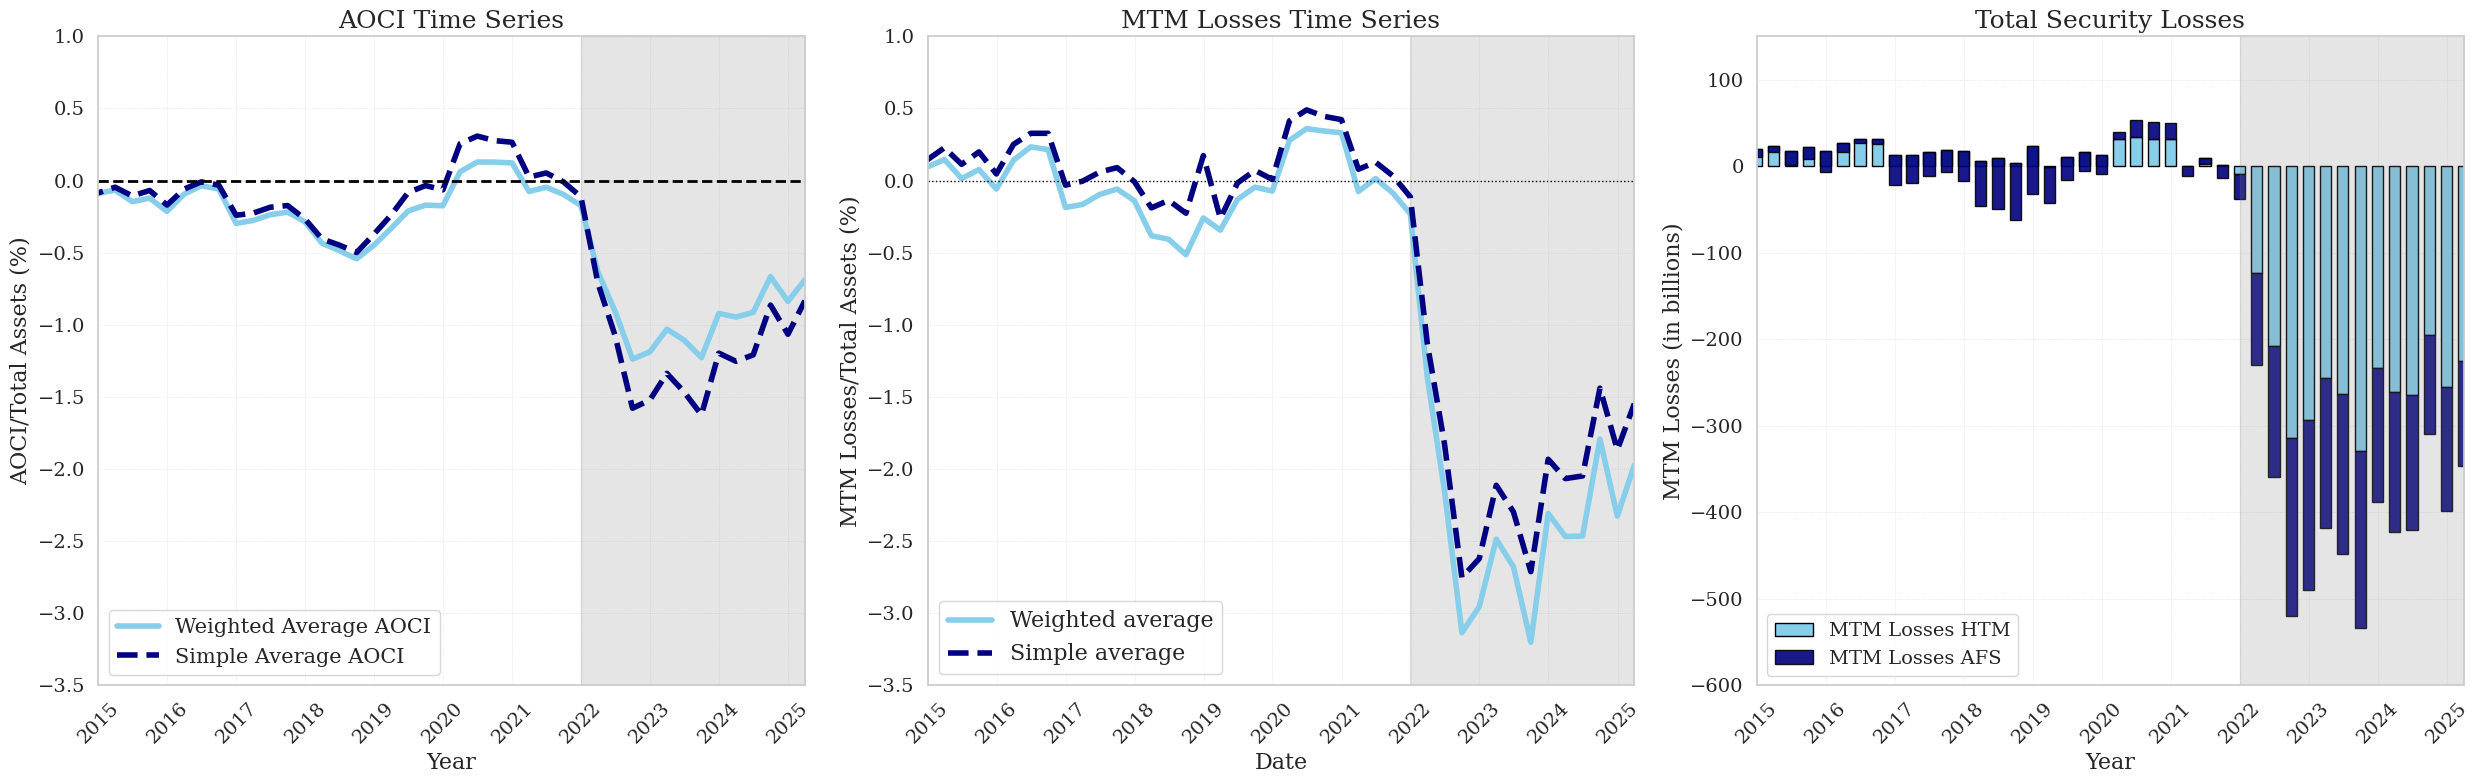

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
# ----------------------------------------------------------------------------------------------
# Plot 1: AOCI Time Series
sns.lineplot(ax=axes[0], data=weighted_avg_aoci, x='Date', y='AOCI %', 
             label='Weighted Average AOCI', linewidth=4, color='skyblue')
sns.lineplot(ax=axes[0], data=simple_avg_aoci, x='Date', y='AOCI %', 
             label='Simple Average AOCI', linewidth=4, linestyle='--', color='navy')
axes[0].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0].fill_betweenx(y=[-4, 1],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[0].legend(fontsize=15, loc='lower left')
axes[0].set_xlabel('Year', fontsize=16)
axes[0].set_ylabel('AOCI/Total Assets (%)', fontsize=16)
axes[0].set_title('AOCI Time Series', fontsize=18)
axes[0].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[0].set_ylim(-3.5, 1)
axes[0].tick_params(axis='x', labelsize=14, rotation=45)
axes[0].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
# Plot 2: Weighted MTM Losses
sns.lineplot(ax=axes[1], data=weighted_avg_mtm, x='Date', y='MTM Losses %',
             lw=4, errorbar=None, label='Weighted average', linestyle='-', color='skyblue')
sns.lineplot(ax=axes[1], data=simple_avg_mtm, x='Date', y='MTM Losses %',
             lw=4, errorbar=None, linestyle='--', label='Simple average', color='navy')
axes[1].axhline(0, lw=1, ls=':', color='black')
axes[1].legend(loc='lower left', fontsize=16)
axes[1].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[1].fill_betweenx(y=[-11, 2.5],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].set_ylabel('MTM Losses/Total Assets (%)', fontsize=16)
axes[1].set_title('MTM Losses Time Series', fontsize=18)
axes[1].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[1].set_ylim(-3.5, 1)
axes[1].tick_params(axis='x', labelsize=14, rotation=45)
axes[1].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
# Plot 3: stacked barplot of MTM losses

# Define a thicker bar width
bar_width = 60  # adjust as needed

# Plot the first (bottom) bar: MTM Losses HTM using the same skyblue as in axes[0] and [2]
axes[2].bar(mtm_agg['Date'], mtm_agg['MTM Losses HTM'], 
            width=bar_width, color='skyblue', label='MTM Losses HTM', edgecolor='black')

# Plot the second bar on top: MTM Losses AFS using the default second palette color
axes[2].bar(mtm_agg['Date'], mtm_agg['MTM Losses AFS'], 
            width=bar_width, bottom=mtm_agg['MTM Losses HTM'], 
            label='MTM Losses AFS', edgecolor='black', color='navy', alpha=0.9)

# Set title and labels directly on axes[1]
axes[2].set_title('Total Security Losses', fontsize=18)
axes[2].set_xlabel('Year', fontsize=16)
axes[2].set_ylabel('MTM Losses (in billions)', fontsize=16)

# Configure x-axis to show only years
axes[2].tick_params(axis='x', labelsize=14, rotation=45)
axes[2].fill_betweenx(y=[-800, 200],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[2].legend(fontsize=14, loc='lower left')
axes[2].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[2].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[2].set_ylim(-600, 150)
axes[2].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
plt.tight_layout()
plt.show()

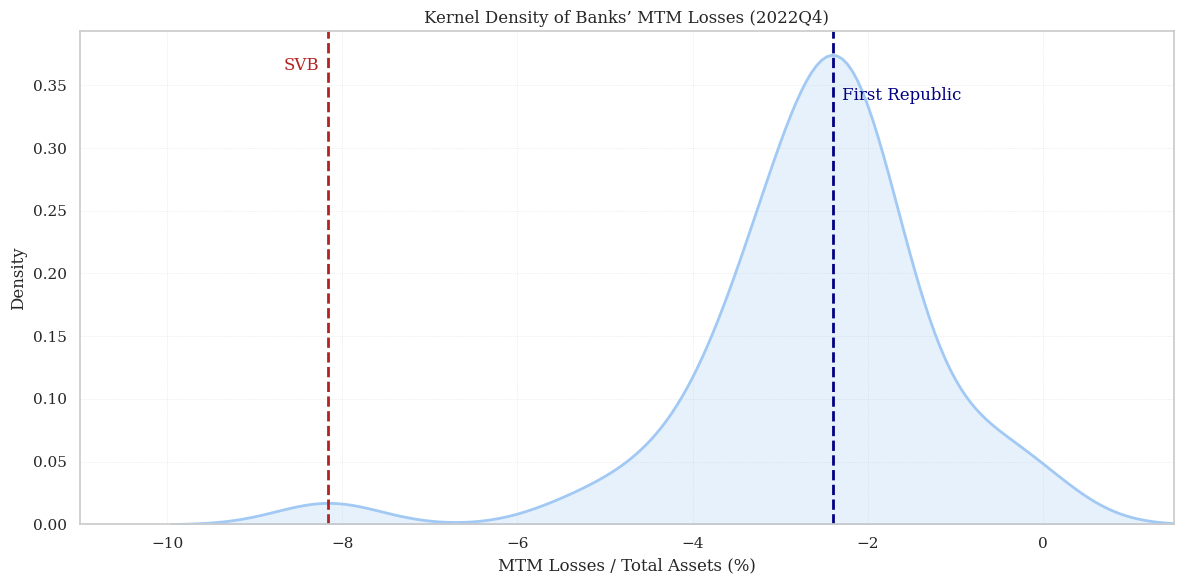

In [33]:
# Get the last available date in 2022
last_date = '2022-12-31'  # Assuming the last date is December 31, 2022

# Select rows corresponding to this last date
data_last = df_temp[df_temp['Date'] == last_date].copy()

# --------------------------------------------------
# 2  DATA FOR 2022-Q4
# --------------------------------------------------
last_date   = "2022-12-31"
data_last   = df_temp[df_temp["Date"] == last_date].copy()

svb_mtm_loss = data_last.loc[data_last["IDRSSD"] == 802866,  "MTM Losses %"].iat[0]
frb_mtm_loss = data_last.loc[data_last["IDRSSD"] == 4114567, "MTM Losses %"].iat[0]
svb_aoci = data_last.loc[data_last["IDRSSD"] == 802866, "AOCI %"].iat[0]
frb_aoci = data_last.loc[data_last["IDRSSD"] == 4114567, "AOCI %"].iat[0]

# --------------------------------------------------
# 3  KDE PLOT
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(
    data      = data_last,
    x         = "MTM Losses %",
    bw_adjust = 0.9,       # ↓ tweak for smoother/rougher curve
    fill      = True,
    alpha     = 0.25,
    linewidth = 2,
    ax        = ax
)

# Reference lines + labels
ax.axvline(svb_mtm_loss, color="firebrick", ls="--", lw=2)
ax.text(svb_mtm_loss-0.1, ax.get_ylim()[1]*0.93, "SVB",
        color="firebrick", ha="right", va="center")

ax.axvline(frb_mtm_loss, color="navy", ls="--", lw=2)
ax.text(frb_mtm_loss+0.1, ax.get_ylim()[1]*0.87, "First Republic",
        color="navy", ha="left",  va="center")

# Axes / title tweaks
ax.set_xlim(-11, 1.5)
ax.set_xlabel("MTM Losses / Total Assets (%)")
ax.set_ylabel("Density")
ax.set_title("Kernel Density of Banks’ MTM Losses (2022Q4)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7, color='lightgrey')
plt.tight_layout()
plt.show()


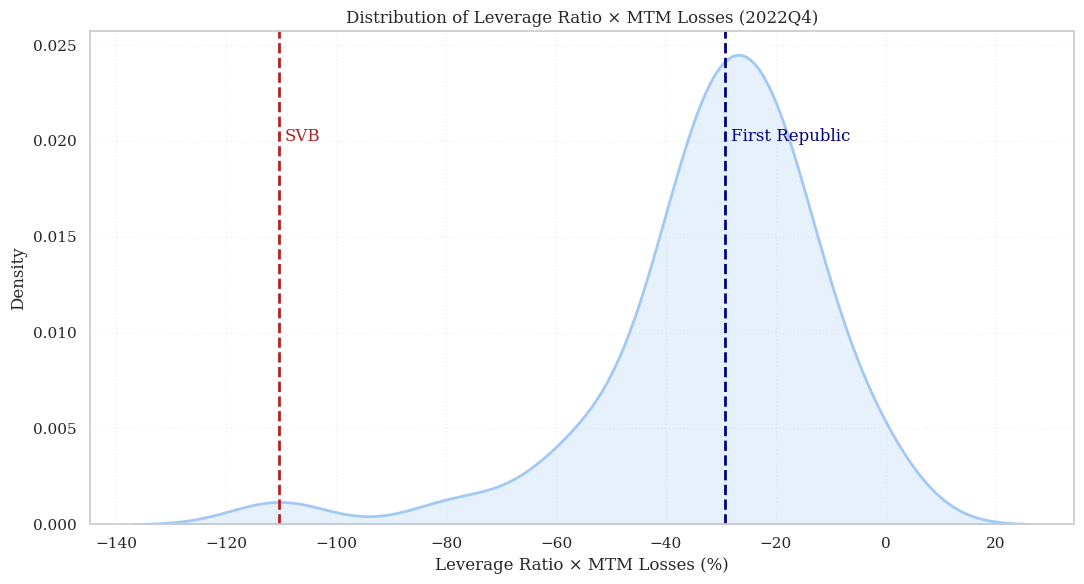

In [34]:
# Create the new variable: Leverage Ratio * MTM Losses %
data_last['Leverage MTM Losses'] = data_last['Leverage Ratio'] * data_last['MTM Losses %']

# Get values for SVB and First Republic
svb_leverage_mtm = data_last.loc[data_last["IDRSSD"] == 802866, "Leverage MTM Losses"].iat[0]
frb_leverage_mtm = data_last.loc[data_last["IDRSSD"] == 4114567, "Leverage MTM Losses"].iat[0]

# Create histogram
fig, ax = plt.subplots(figsize=(11, 6))

# Plot histogram
sns.kdeplot(
    data      = data_last,
    x         = "Leverage MTM Losses",
    bw_adjust = 0.9,       # ↓ tweak for smoother/rougher curve
    fill      = True,
    alpha     = 0.25,
    linewidth = 2,
    ax        = ax
)

# Add reference lines for SVB and First Republic
ax.axvline(svb_leverage_mtm, color='firebrick', linestyle='--', linewidth=2, label='SVB')
# write the name of 'SVB' next to the line:
ax.text(svb_leverage_mtm+1, 0.02, 'SVB', color='firebrick', fontsize=12)

ax.axvline(frb_leverage_mtm, color='navy', linestyle='--', linewidth=2, label='First Republic')
ax.text(frb_leverage_mtm+1, 0.02, 'First Republic', color='navy', fontsize=12)

# Customize the plot
ax.set_xlabel('Leverage Ratio × MTM Losses (%)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Leverage Ratio × MTM Losses (2022Q4)')
ax.grid(True, alpha=0.3, linestyle=':', color='lightgray')
plt.tight_layout()
plt.show()

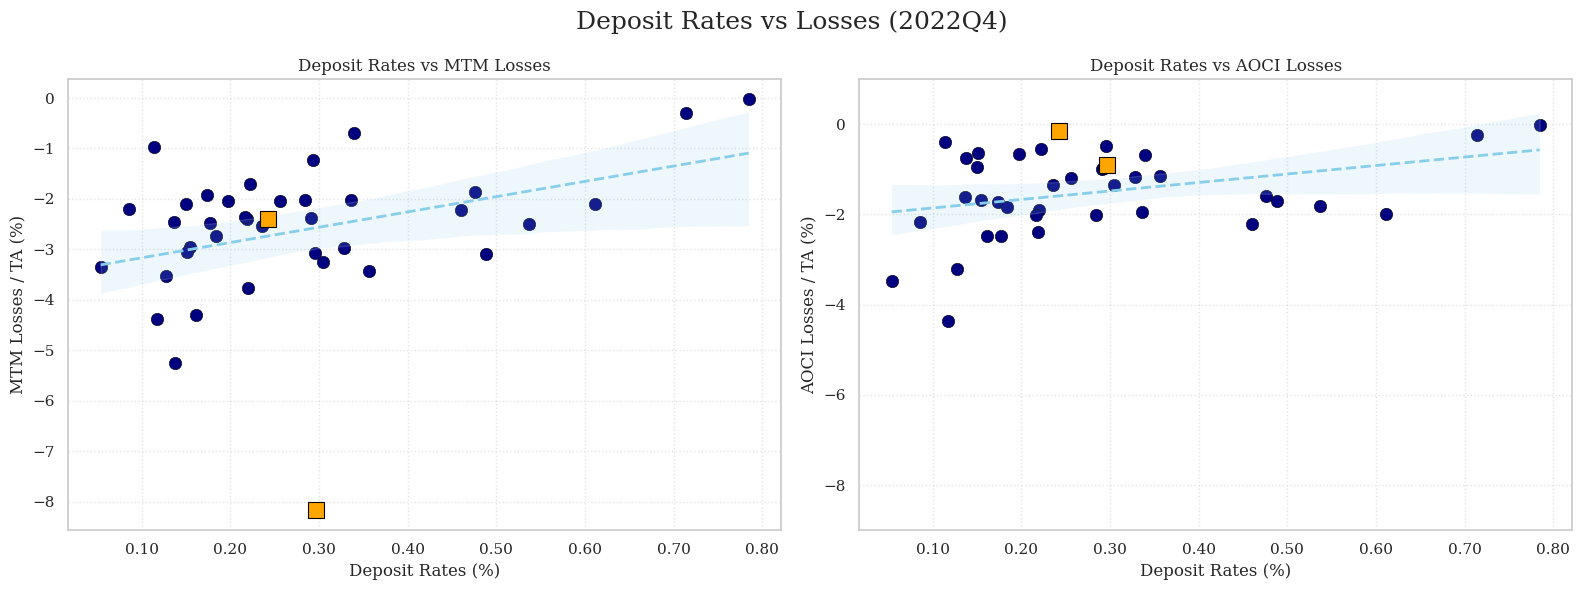

In [35]:
# 1 ────────────────────────────────────────────────
#   FIGURE WITH A SHARED Y-AXIS
# ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)  # ← sharey=True

# ─── scatter #1 ───────────────────────────────────
sns.scatterplot(
    ax        = axes[0],
    data      = data_last,
    x         = "Deposit Rates",
    y         = "MTM Losses %",
    s         = 80,
    color     = "navy",
    edgecolor = "black",
    linewidth = 0.4
)
# add a regression plot:
sns.regplot(
    ax        = axes[0],
    data      = data_last,
    x         = "Deposit Rates",
    y         = "MTM Losses %",
    scatter   = False,
    line_kws  = {"linewidth": 2, "linestyle": "--", "color": "skyblue"}
)

axes[0].scatter(
    data_last.loc[data_last["IDRSSD"] == 802866, "Deposit Rates"],
    svb_mtm_loss,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
# add First Republic as an orange square:
axes[0].scatter(
    data_last.loc[data_last["IDRSSD"] == 4114567, "Deposit Rates"],
    frb_mtm_loss,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
axes[0].set_ylabel("MTM Losses / TA (%)")
axes[0].set_title("Deposit Rates vs MTM Losses")

# ─── scatter #2 ───────────────────────────────────
sns.scatterplot(
    ax        = axes[1],
    data      = data_last,
    x         = "Deposit Rates",
    y         = "AOCI %",
    s         = 80,
    color     = "navy",
    edgecolor = "black",
    linewidth = 0.4
)
# add a regression line:
sns.regplot(
    ax        = axes[1],
    data      = data_last,
    x         = "Deposit Rates",
    y         = "AOCI %",
    scatter   = False,
    line_kws  = {"linewidth": 2, "linestyle": "--", "color": "skyblue"}
)
                 
axes[1].scatter(
    data_last.loc[data_last["IDRSSD"] == 802866, "Deposit Rates"],
    svb_aoci,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
# add First Republic as an orange square:
axes[1].scatter(
    data_last.loc[data_last["IDRSSD"] == 4114567, "Deposit Rates"],
    frb_aoci,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
axes[1].set_ylabel("AOCI Losses / TA (%)")
axes[1].set_title("Deposit Rates vs AOCI Losses")

# 2 ────────────────────────────────────────────────
#   FORCE IDENTICAL Y-TICK LOCATIONS
# ──────────────────────────────────────────────────
# Build a common tick vector from the union of both series
y_all   = np.concatenate([data_last["MTM Losses %"].values,
                          data_last["AOCI %"].values])
y_min   = np.floor(y_all.min())
y_max   = np.ceil(y_all.max()+0.1)
plt.ylim(y_min, y_max)

# ─── shared X formatting ─────────────────────────
for ax in axes:
    ax.set_xlabel("Deposit Rates (%)")
    ax.grid(True, linestyle=":", alpha=0.6, color="lightgray")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.2f}"))

plt.suptitle("Deposit Rates vs Losses (2022Q4)", fontsize=18)
plt.tight_layout()
plt.show()


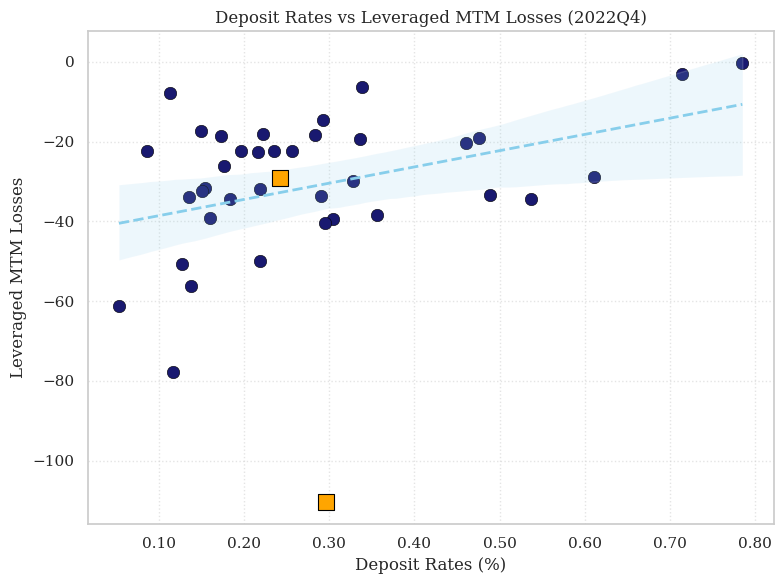

In [36]:
# 1 ────────────────────────────────────────────────
#   FIGURE WITH SINGLE PLOT
# ──────────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# ─── scatter plot ───────────────────────────────────
sns.scatterplot(
    ax        = ax,
    data      = data_last,
    x         = "Deposit Rates",
    y         = "Leverage MTM Losses",
    s         = 80,
    color     = "midnightblue",
    edgecolor = "black",
    linewidth = 0.4
)
sns.regplot(
    ax        = ax,
    data      = data_last,
    x         = "Deposit Rates",
    y         = "Leverage MTM Losses",
    scatter   = False,
    line_kws  = {"linewidth": 2, "linestyle": "--", "color": "skyblue"}
)

ax.scatter(
    data_last.loc[data_last["IDRSSD"] == 802866, "Deposit Rates"],
    data_last.loc[data_last["IDRSSD"] == 802866, "Leverage MTM Losses"],
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
# add First Republic as an orange square:
ax.scatter(
    data_last.loc[data_last["IDRSSD"] == 4114567, "Deposit Rates"],
    data_last.loc[data_last["IDRSSD"] == 4114567, "Leverage MTM Losses"],
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
ax.set_ylabel("Leveraged MTM Losses")
ax.set_xlabel("Deposit Rates (%)")
ax.set_title("Deposit Rates vs Leveraged MTM Losses (2022Q4)")
ax.grid(True, linestyle=":", alpha=0.6, color="lightgray")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.2f}"))

plt.tight_layout()
plt.show()


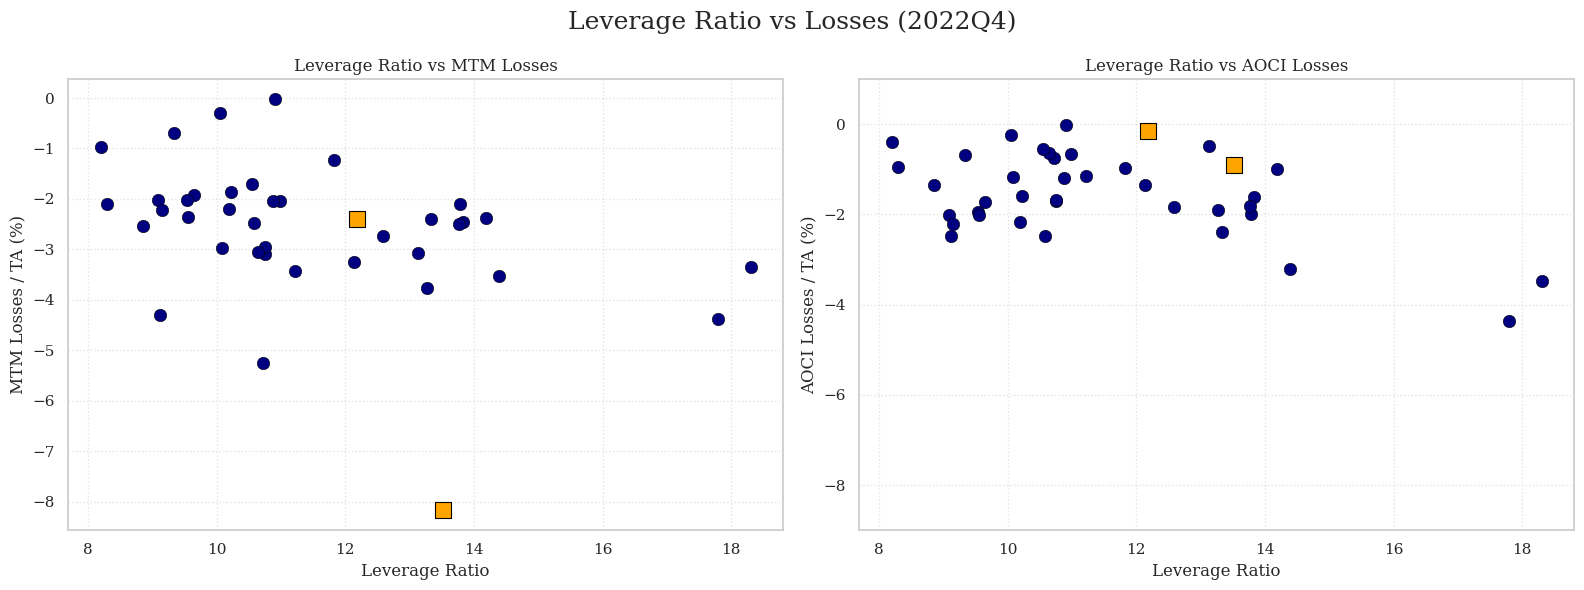

In [37]:
# 1 ────────────────────────────────────────────────
#   FIGURE WITH A SHARED Y-AXIS
# ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)  # ← sharey=True

# ─── scatter #1 ───────────────────────────────────
sns.scatterplot(
    ax        = axes[0],
    data      = data_last,
    x         = "Leverage Ratio",
    y         = "MTM Losses %",
    s         = 80,
    color     = "navy",
    edgecolor = "black",
    linewidth = 0.4
)
axes[0].scatter(
    data_last.loc[data_last["IDRSSD"] == 802866, "Leverage Ratio"],
    svb_mtm_loss,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
# add First Republic as an orange square:
axes[0].scatter(
    data_last.loc[data_last["IDRSSD"] == 4114567, "Leverage Ratio"],
    frb_mtm_loss,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
axes[0].set_ylabel("MTM Losses / TA (%)")
axes[0].set_title("Leverage Ratio vs MTM Losses")

# ─── scatter #2 ───────────────────────────────────
sns.scatterplot(
    ax        = axes[1],
    data      = data_last,
    x         = "Leverage Ratio",
    y         = "AOCI %",
    s         = 80,
    color     = "navy",
    edgecolor = "black",
    linewidth = 0.4
)
axes[1].scatter(
    data_last.loc[data_last["IDRSSD"] == 802866, "Leverage Ratio"],
    svb_aoci,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
# add First Republic as an orange square:
axes[1].scatter(
    data_last.loc[data_last["IDRSSD"] == 4114567, "Leverage Ratio"],
    frb_aoci,
    marker="s", s=120, color="orange", edgecolor="black", linewidth=0.8, zorder=5
)
axes[1].set_ylabel("AOCI Losses / TA (%)")
axes[1].set_title("Leverage Ratio vs AOCI Losses")

# 2 ────────────────────────────────────────────────
#   FORCE IDENTICAL Y-TICK LOCATIONS
# ──────────────────────────────────────────────────
# Build a common tick vector from the union of both series
y_all   = np.concatenate([data_last["MTM Losses %"].values,
                          data_last["AOCI %"].values])
y_min   = np.floor(y_all.min())
y_max   = np.ceil(y_all.max()+0.1)
plt.ylim(y_min, y_max)

# ─── shared X formatting ─────────────────────────
for ax in axes:
    ax.set_xlabel("Leverage Ratio")
    ax.grid(True, linestyle=":", alpha=0.6, color="lightgray")

plt.suptitle("Leverage Ratio vs Losses (2022Q4)", fontsize=18)
plt.tight_layout()
plt.show()


### Deposit Franchise Hedge

In [38]:
df = df_temp.copy()

In [39]:
# -----------------------------------------------
# 1.  Pull constant-maturity Treasury yields
#     straight from FRED and convert to quarterly
# -----------------------------------------------
fred_tickers = {
    0.083: "DGS1MO",   # 1-month  ≈ 0.083 y
    0.25 : "DGS3MO",
    0.5  : "DGS6MO",
    1    : "DGS1",
    2    : "DGS2",
    3    : "DGS3",
    5    : "DGS5",
    7    : "DGS7",
    10   : "DGS10",
    20   : "DGS20",
    30   : "DGS30",
}

start = "2001-01-01"

# Grab the whole panel in one call
yc_q = (
    pdr.DataReader(list(fred_tickers.values()), data_source="fred", start=start)
      .rename(columns={v: k for k, v in fred_tickers.items()})
      .div(100.0)            # 4.25 %  →  0.0425
      .resample("QE")         # quarter-end calendar
      .last()                # pick the last obs each quarter
      .reset_index()
)

# Rename 'DATE' to 'Date'
yc_q.rename(columns={'DATE': 'Date'}, inplace=True)

In [40]:
# ------------------------------------------------
# 2 & 3  —- interpolate & compute weighted yield
#         (identical to the previous snippet)
# ------------------------------------------------
bucket_mid = {
    "Yield (3M-)"     : 0.125,
    "Yield (3M-1Y)"   : 0.75,
    "Yield (1Y-3Y)"   : 2.0,
    "Yield (3Y-5Y)"   : 4.0,
    "Yield (5Y-15Y)"  : 10.0,
    "Yield (15Y+)"    : 15.0,
}
mids = np.array(list(bucket_mid.values()), dtype=float)

In [41]:
# Make sure the whole matrix is float64 (gets rid of the 'Float64' dtype), except for 'Date':
yc_q = yc_q.astype({col: 'float64' for col in yc_q.columns if col != 'Date'})

# ── 2·1  Keep only numeric-labelled columns (the maturity nodes) ──
# If anything like 'Date' or 'Note' is in the columns, drop it here.
maturity_cols       = pd.to_numeric(yc_q.columns, errors="coerce")
yc_q_num            = yc_q.loc[:, maturity_cols.notna()]      # keep numeric labels only
yc_q_num.columns    = maturity_cols[maturity_cols.notna()].astype(float)

# ── 2·2  Ensure all data are float64 so np.interp is happy ──
yc_q_num = yc_q_num.astype(float)

In [42]:
yc_q_buckets = (
    yc_q_num.apply(interp_row, axis=1, result_type="expand", mids_array=mids)
            .set_axis(bucket_mid.keys(), axis=1)
)

# concatenate the original date column with the new bucketed yields:
yc_q_buckets = pd.concat([yc_q[['Date']], yc_q_buckets], axis=1)

yield_cols = list(yc_q_buckets.columns[1:])

treas_cols = [
    "Treasuries (3M-)",
    "Treasuries (3M-1Y)",
    "Treasuries (1Y-3Y)",
    "Treasuries (3Y-5Y)",
    "Treasuries (5Y-15Y)",
    "Treasuries (15Y+)",
]

In [43]:
# merge df and yc_q_buckets on 'Date'
df = df.merge(yc_q_buckets, on='Date', how='left')

In [44]:
num = (df[treas_cols].values * df[yield_cols].values).sum(1)
den = df[treas_cols].sum(1)
df["Treasuries Weighted Yield"] = num / den

In [45]:
df['Deposit Business Profits'] = 100*(
    ((df['Treasuries Weighted Yield'] - df['Deposit Rates']) * df['Total Deposits'] - df['Non Interest Expenses'])/ 
    df['Total Assets']
    )
df['FedFunds Rate'] = df['FedFunds Rate'] * 100  # convert to percentage

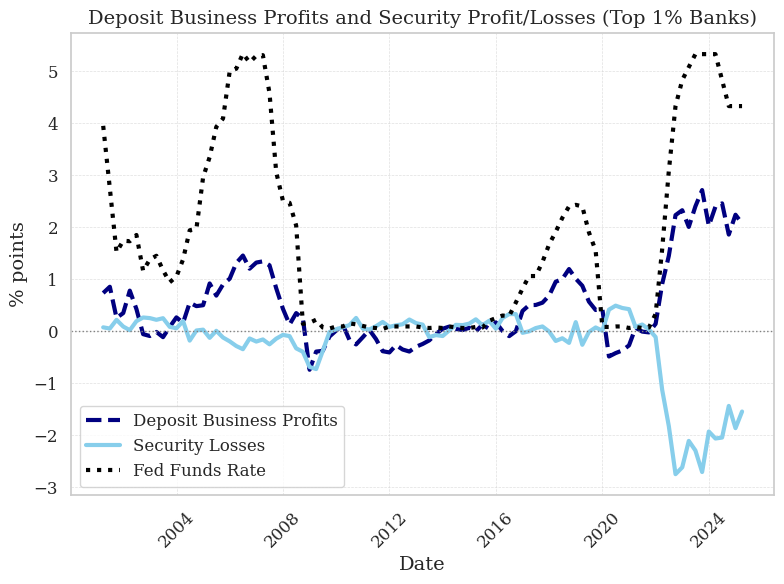

In [46]:
# use seaborn to plot 'Deposit Expenses Ratio' and 'MTM Losses %' on the same line plot:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df,
    x='Date',
    y='Deposit Business Profits',
    label='Deposit Business Profits',
    linewidth=3,
    linestyle='--',
    errorbar=None,
    color='navy'
)
sns.lineplot(
    data=df,
    x='Date',
    y='MTM Losses %',
    label='Security Losses',
    linewidth=3,
    linestyle='-',
    errorbar=None,
    color='skyblue'
)

# add Fed Funds Rate to the plot:
sns.lineplot(
    data=df,
    x='Date',
    y='FedFunds Rate',
    label='Fed Funds Rate',
    linewidth=3,
    linestyle=':',
    errorbar=None,
    color='black'
)

# add a horizontal line at y=0:
plt.axhline(0, color='gray', linestyle=':', linewidth=1)

plt.title('Deposit Business Profits and Security Profit/Losses (Top 1% Banks)',
            fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('% points', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, loc='lower left')
plt.tight_layout()
plt.show()

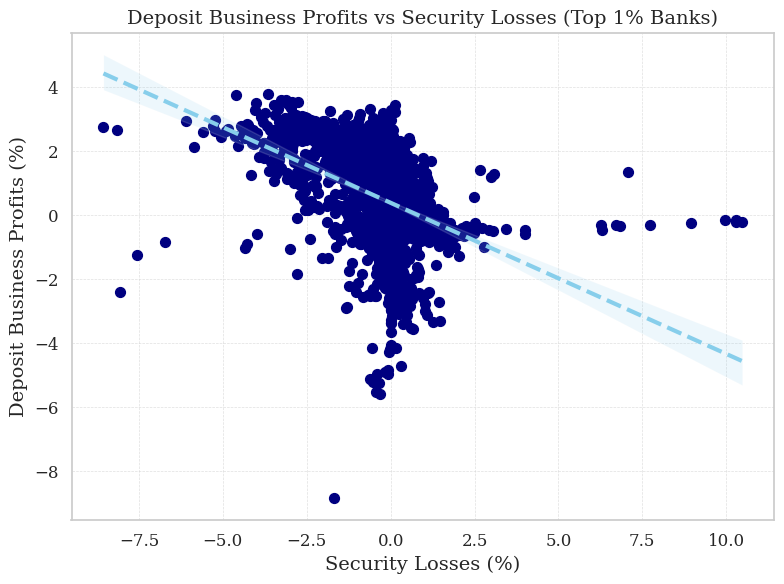

In [107]:
# use regplot to plot 'Deposit Business Profits' vs 'MTM Losses %' with a regression line:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x='MTM Losses %',
    y='Deposit Business Profits',
    scatter_kws={'s': 50, 'color': 'navy', 'alpha':1},
    line_kws={'color': 'skyblue', 'linewidth': 3, 'linestyle': '--'},
    ci=95
)
plt.title('Deposit Business Profits vs Security Losses (Top 1% Banks)', fontsize=14)
plt.xlabel('Security Losses (%)', fontsize=14)
plt.ylabel('Deposit Business Profits (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

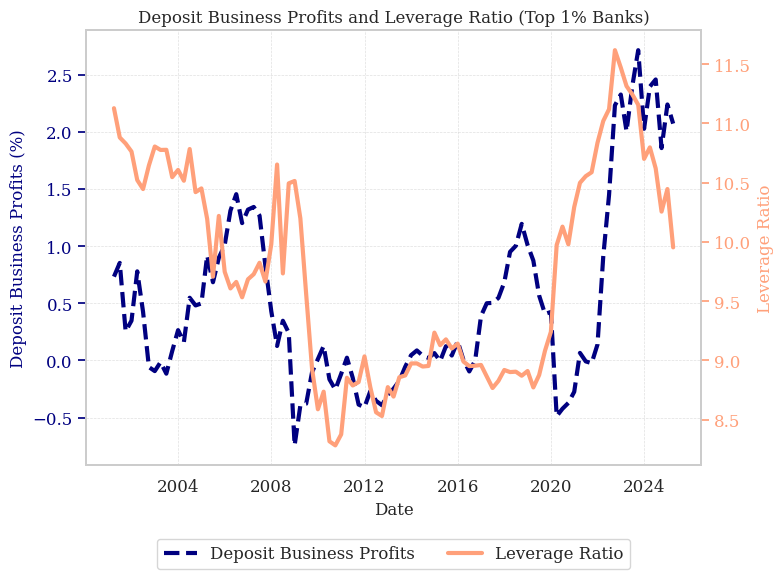

In [131]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot 'Deposit Business Profits' on the primary y-axis with navy color
sns.lineplot(
    data=df,
    x='Date',
    y='Deposit Business Profits',
    ax=ax1,
    color='navy',
    linewidth=3,
    linestyle='--',
    errorbar=None, 
    label='Deposit Business Profits'
)
# Set the y-label and tick colors for ax1
ax1.set_ylabel('Deposit Business Profits (%)', fontsize=12, color='navy')
ax1.tick_params(axis='y', colors='navy', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel('Date', fontsize=12)

# Create a secondary y-axis for 'Leverage Ratio'
ax2 = ax1.twinx()
sns.lineplot(
    data=df,
    x='Date',
    y='Leverage Ratio',
    ax=ax2,
    color='lightsalmon',
    linewidth=3,
    errorbar=None,
    label='Leverage Ratio'
)
# Set the y-label and tick colors for ax2
ax2.set_ylabel('Leverage Ratio', fontsize=12, color='lightsalmon')
ax2.tick_params(axis='y', colors='lightsalmon', labelsize=12)

plt.title('Deposit Business Profits and Leverage Ratio (Top 1% Banks)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='lightgray')
ax2.grid(False)

# Remove any existing legend on ax1
if ax1.get_legend() is not None:
    ax1.get_legend().remove()

# Combine legends from both axes into one box:
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2,
           loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=2, frameon=True, fontsize=12)

plt.tight_layout()
plt.show()

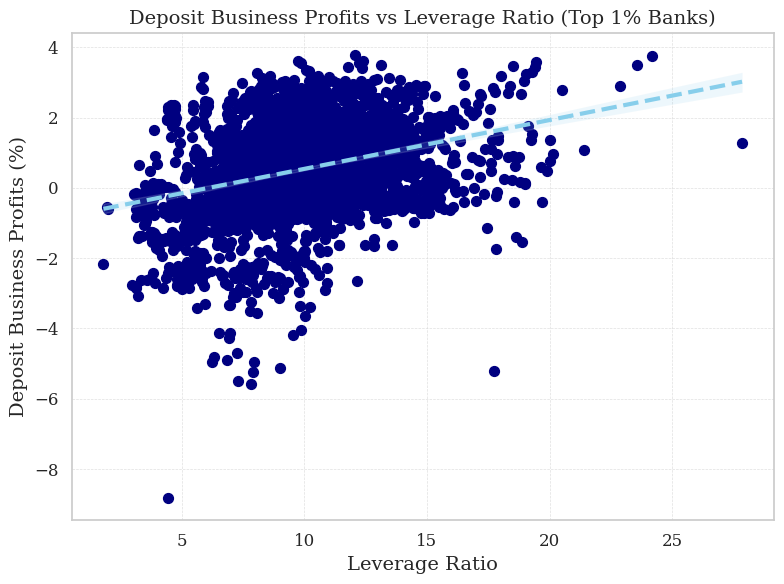

In [117]:
# make a scatter plot of 'Deposit Business Profits' vs 'Leverage Ratio' with a regression line:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x='Leverage Ratio',
    y='Deposit Business Profits',
    scatter_kws={'s': 50, 'color': 'navy', 'alpha':1},
    line_kws={'color': 'skyblue', 'linewidth': 3, 'linestyle': '--'},
    ci=95
)
plt.title('Deposit Business Profits vs Leverage Ratio (Top 1% Banks)', fontsize=14)
plt.xlabel('Leverage Ratio', fontsize=14)
plt.ylabel('Deposit Business Profits (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5
, color='lightgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### HTM vs. AFS shares

In [ ]:
df = df_top1.copy()

In [ ]:
# compute the 'Share of AFS':
df['Share of AFS'] = df['AFS Securities'] / (df['HTM Securities'] + df['AFS Securities'])
# compute the 'Share of HTM':
df['Share of HTM'] = df['HTM Securities'] / (df['HTM Securities'] + df['AFS Securities'])

In [ ]:
# Aggregate the two shares per Date (already in your code)
grp = (
    df.groupby("Date", sort=True)[["Share of AFS", "Share of HTM"]]
      .mean()  # one observation per Date
      .sort_index()
)
dates = grp.index
xpos  = np.arange(len(dates))

# Also aggregate the Fed Funds Rate:
fed_grp = (
    df.groupby("Date", sort=True)["FedFunds Rate"]
      .mean()
      .sort_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# ── Plot the stacked barplot for shares ─────────────────────────────
ax.bar(
    xpos,
    grp["Share of HTM"],
    label="Share of HTM",
    color=sns.color_palette("Blues")[5]
)
ax.bar(
    xpos,
    grp["Share of AFS"],
    bottom=grp["Share of HTM"],
    label="Share of AFS",
    color=sns.color_palette("Blues")[2]
)

# X-axis tick thinning (show about 10 ticks)
max_ticks = 10
step = max(1, len(dates) // max_ticks)
ax.set_xticks(xpos[::step])
ax.set_xticklabels(pd.to_datetime(dates[::step]).strftime("%Y"), rotation=45)
ax.set_ylim(0, 1)
ax.set_ylabel("Share of Total Securities")
ax.set_title("AFS vs HTM Securities Shares Over Time")

# ── Create a second y-axis for Fed Funds Rate ─────────────────────────
ax2 = ax.twinx()
ax2.plot(
    xpos,
    fed_grp,
    color="black",
    linestyle=":",
    linewidth=4,
    label="Fed Funds Rate"
)
ax2.set_ylabel("Fed Funds Rate (%)")
# add the formatter for the second y-axis, multiply by 100:
formatter = FuncFormatter(lambda x, pos: f'{x*100:.2f}')
ax2.yaxis.set_major_formatter(formatter)
ax2.grid(False)  # Disable grid on the second y-axis

# ── Combine the legends from both axes ────────────────────────────────
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines + lines2,
    labels + labels2,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

sns.despine(trim=True)
ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7, color="lightgray")
plt.tight_layout()
plt.show()

In [ ]:
# do the same plot only for SVB:
df_svb = df[df['Financial Institution Name'] == 'SILICON VALLEY BANK'].copy()

# ── 1.  Aggregate to one observation per Date ────────────────────────────────
# (If your df already has one row per date, this is just a harmless mean.)
grp_svb = (
    df_svb.groupby("Date", sort=True)[["Share of AFS", "Share of HTM"]]
      .mean()                           # returns a 2-column frame indexed by Date
      .sort_index()
)

# ── 2.  Positions & bars ─────────────────────────────────────────────────────
dates_svb = grp_svb.index
xpos_svb  = np.arange(len(dates_svb))
fig, ax = plt.subplots(figsize=(12, 6))
# 1️⃣  Bottom layer  →  HTM
ax.bar(
    xpos_svb,
    grp_svb["Share of HTM"],
    label="Share of HTM",
    color=sns.color_palette("Blues")[5]
)
# 2️⃣  Top layer     →  AFS  (bottom = HTM heights)
ax.bar(
    xpos_svb,
    grp_svb["Share of AFS"],
    bottom=grp_svb["Share of HTM"],
    label="Share of AFS",
    color=sns.color_palette("Blues")[2]
)
# ── 3.  X-axis tick thinning ────────────────────────────────────────────────
# Show at most ~10 ticks.
max_ticks = 10
step      = max(1, len(dates_svb) // max_ticks)
ax.set_xticks(xpos_svb[::step])
ax.set_xticklabels(pd.to_datetime(dates_svb[::step]).strftime("%Y"), rotation=45)
# ── 4.  Cosmetics ────────────────────────────────────────────────────────────
ax.set_ylim(0, 1)
ax.set_ylabel("Share of Total Securities")
ax.set_title("AFS vs HTM Securities Shares Over Time (SVB Only)")
plt.subplots_adjust(bottom=0.18)     # leave room for legend
fig.legend(
    ["Share of HTM", "Share of AFS"], # ← order matches stack
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)
sns.despine(trim=True)
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7, color='lightgray')
plt.tight_layout()
plt.show()

### Scatter plots

#### Plots for top X% banks

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Loans', 'Total Deposits', 'Total Assets', 'Uninsured Deposits',
           'AOCI', 'Total Equity Capital',
           'Securities AC', 'Securities FV']].copy()


In [ ]:
df = df[(df['Date']=='2019-03-31') | (df['Date']=='2021-12-31')]
df = df.sort_values(by=['IDRSSD', 'Date']).reset_index(drop=True)

In [ ]:
# Get the total number of unique dates in the DataFrame
total_dates = df['Date'].nunique()

# Identify banks that appear in all dates
banks_all_dates = df.groupby('IDRSSD')['Date'].nunique() == total_dates
banks_to_keep = banks_all_dates[banks_all_dates].index

# Filter the DataFrame to keep only these banks
df = df[df['IDRSSD'].isin(banks_to_keep)].reset_index(drop=True)

In [ ]:
failed_banks = [802866, 4114567, 3437483]
#failed_banks = [802866, 4114567]

In [ ]:
# create auxiliar dataset with only '2019-03-31':
df_aux = df[df['Date'] == '2019-03-31'].copy()

In [ ]:
# take the top 1% banks in 'Total Assets' in '2019-03-31':
percentile = 0.99
top_percentile_assets = df_aux['Total Assets'].quantile(percentile)
top_percentile_deposits = df_aux['Total Deposits'].quantile(percentile)

In [ ]:
# filter the DataFrame to keep only these banks:
df_top_percentile = df_aux[df_aux['Total Assets'] >= top_percentile_assets].reset_index(drop=True)
top_percent_banks = df_top_percentile['IDRSSD'].unique()

In [ ]:
# --- 1.  Prepare figure with 3 columns instead of 2 --------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# --- 2.  Your two cumulative-histogram panels (unchanged) --------------------
ax1.hist(np.log(df['Total Assets']), bins=50, cumulative=True,
         color='skyblue', alpha=0.7, density=True)
ax1.set_title(f'Cumulative Distribution of Total Assets '
              f'(Top {np.round(100*(1-percentile),1)}% Banks)', fontsize=18)
ax1.set_xlabel('log(Total Assets)', fontsize=16);  ax1.set_ylabel('Density', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(ls=':', color='lightgrey');  
ax1.axvline(np.log(top_percentile_assets), ls='--', color='lightcoral',
            label=f'{percentile}th Percentile')
ax1.legend(fontsize=12)

ax2.hist(np.log(df['Total Deposits']), bins=50, cumulative=True,
         color='skyblue', alpha=0.7, density=True)
ax2.set_title(f'Cumulative Distribution of Total Deposits '
              f'(Top {np.round(100*(1-percentile),1)}% Banks)', fontsize=18)
ax2.set_xlabel('log(Total Deposits)', fontsize=16);  ax2.set_ylabel('Density', fontsize=16)
ax2.grid(ls=':', color='lightgrey')
ax2.axvline(np.log(top_percentile_deposits), ls='--', color='lightcoral',
            label=f'{percentile}th Percentile')
ax2.legend(fontsize=14, frameon=False)

# --- 3.  Lorenz-style concentration panel -----------------------------------
plot_specs = [
    ('Total Deposits', 'skyblue', 'Deposits'),
    ('Total Assets',       'lightcoral',    'Assets'),
#    ('Uninsured Deposits', 'green',   'Uninsured Deposits'),
#    ('Securities AC',      'orange', 'Securities (AC)')
]

for col, clr, lbl in plot_specs:
    x, y = lorenz_points(df[col].fillna(0))
    ax3.scatter(x, y, s=18, color=clr, alpha=0.85, label=lbl)

ax3.set_title('Concentration of Uninsured Deposits and Assets',
              fontsize=18)
ax3.set_xlabel('Share of Banks', fontsize=16);  ax3.set_ylabel('Share of Total', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-0.02, 1.02);                ax3.set_ylim(-0.02, 1.02)
ax3.grid(ls=':', color='lightgrey')
ax3.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
df2 = df[df['IDRSSD'].isin(top_percent_banks)].sort_values(by='Total Assets', ascending=False)
df2.sort_values(by=['Date', 'Total Assets'], ascending=[True, False], inplace=True)

In [ ]:
# compute the growth rate of 'Securities AC' and 'Total Loans', and 'Total Deposits':
df2['Securities AC Growth'] = df2.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
df2['Securities FV Growth'] = df2.groupby('IDRSSD')['Securities FV'].pct_change(fill_method=None)
df2['Loans Growth'] = df2.groupby('IDRSSD')['Total Loans'].pct_change(fill_method=None)
df2['Deposits Growth'] = df2.groupby('IDRSSD')['Total Deposits'].pct_change(fill_method=None)
df2['Uninsured Deposits Growth'] = df2.groupby('IDRSSD')['Uninsured Deposits'].pct_change(fill_method=None)
df2['Equity Capital Growth'] = df2.groupby('IDRSSD')['Total Equity Capital'].pct_change(fill_method=None)
df2['AOCI Growth'] = df2.groupby('IDRSSD')['AOCI'].pct_change(fill_method=None)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Deposits Growth'], df2['Securities AC Growth'], marker='o', s=50, color='midnightblue')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Deposits Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
ticks1 = ax1.get_yticks()
ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 6)
ax1.set_ylim(-1.1, 6)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Deposits Growth'], df2['Loans Growth'], marker='o', s=50, color='midnightblue')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
lims2 = [min(ax1.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 6)
ax2.set_ylim(-1.1, 6)
# use the same ticks for both axes
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Deposits Growth'], df2['Equity Capital Growth'], marker='o', s=50, color='midnightblue')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax1.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 6)
ax3.set_ylim(-1.1, 6)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Uninsured Deposits Growth'], df2['Securities AC Growth'], marker='o', s=50, color='midnightblue')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Uninsured Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 6)
ax1.set_ylim(-1.1, 6)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Uninsured Deposits Growth'], df2['Loans Growth'], marker='o', s=50, color='midnightblue')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Uninsured Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
lims2 = [min(ax1.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
#ax2.set_xticks(ticks2)
#ax2.set_yticks(ticks2)
ax2.set_xlim(-1.1, 6)
ax2.set_ylim(-1.1, 6)
# use the same ticks for both axes
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Uninsured Deposits Growth'], df2['Equity Capital Growth'], marker='o', s=50, color='midnightblue')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Uninsured Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax1.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 6)
ax3.set_ylim(-1.1, 6)
plt.tight_layout()
plt.show()

In [ ]:
# make the same scatter plot with 'Deposit Growth' in the x-axis and 'Uninsured Deposits Growth' in the y-axis:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df2['Deposits Growth'], df2['Uninsured Deposits Growth'], marker='.', s=50, color='midnightblue')
ax.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            marker='s', s=100, color='orange')
ax.set_xlabel('Deposit Growth', fontsize=16)
ax.set_ylabel('Uninsured Deposits Growth', fontsize=16)
ax.set_title('Deposit Growth vs. Uninsured Deposits Growth', fontsize=18)
ax.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks = ax.get_yticks()
#ax.set_xticks(ticks)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle='--', color='black', alpha=0.5)
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

#### Plots for the whole sample of banks

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Loans', 'Total Deposits', 'Total Assets', 'Uninsured Deposits',
           'AOCI', 'Total Equity Capital',
           'Securities AC',  'Securities FV']].copy()

In [ ]:
df = df[(df['Date']=='2019-03-31') | (df['Date']=='2021-12-31')]
df = df.sort_values(by=['IDRSSD', 'Date']).reset_index(drop=True)

In [ ]:
# Get the total number of unique dates in the DataFrame
total_dates = df['Date'].nunique()

# Identify banks that appear in all dates
banks_all_dates = df.groupby('IDRSSD')['Date'].nunique() == total_dates
banks_to_keep = banks_all_dates[banks_all_dates].index

# Filter the DataFrame to keep only these banks
df = df[df['IDRSSD'].isin(banks_to_keep)].reset_index(drop=True)

In [ ]:
# compute the growth rate of 'Securities AC' and 'Total Loans', and 'Total Deposits':
df['Securities AC Growth'] = df.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
df['Securities FV Growth'] = df.groupby('IDRSSD')['Securities FV'].pct_change(fill_method=None)
df['Loans Growth'] = df.groupby('IDRSSD')['Total Loans'].pct_change(fill_method=None)
df['Deposits Growth'] = df.groupby('IDRSSD')['Total Deposits'].pct_change(fill_method=None)
df['Uninsured Deposits Growth'] = df.groupby('IDRSSD')['Uninsured Deposits'].pct_change(fill_method=None)
df['Equity Capital Growth'] = df.groupby('IDRSSD')['Total Equity Capital'].pct_change(fill_method=None)
df['AOCI Growth'] = df.groupby('IDRSSD')['AOCI'].pct_change(fill_method=None)

In [ ]:
# Drop the rows with NaN values in the 'Securities AC Growth' column
df = df.dropna(subset=['Securities AC Growth', 'Securities FV Growth', 'Equity Capital Growth', 'AOCI Growth', 'Uninsured Deposits Growth',
                        'Loans Growth', 'Deposits Growth', 'Total Assets'])

# show the top 20 banks with the highest growth rate in 'Securities AC Growth':
df.sort_values(by='Securities AC Growth', ascending=False, inplace=True)

In [ ]:
test = df[['IDRSSD', 'Financial Institution Name', 'Total Assets', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)
# take the minimum assets of test:
print(test['Total Assets'].min()*1000/10e5, test['Total Assets'].max()*1000/10e5)
print(test['Securities AC Growth'].min(), test['Securities AC Growth'].max())
test['Total Assets (Millions)'] = test['Total Assets'].apply(lambda x: x*1000/10e5)
outliers_securities = test[['IDRSSD', 'Financial Institution Name', 'Total Assets (Millions)', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)['IDRSSD']

In [ ]:
# exclude outliers_securities from the main DataFrame:
df2 = df[~df['IDRSSD'].isin(outliers_securities)].reset_index(drop=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Deposit Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Uninsured Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Uninsured Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Uninsured Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Uninsured Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Uninsured Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Uninsured Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

In [ ]:
# make the same scatter plot with 'Deposit Growth' in the x-axis and 'Uninsured Deposits Growth' in the y-axis:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df2['Deposits Growth'], df2['Uninsured Deposits Growth'], marker='.')
ax.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            marker='s', s=100, color='orange')
ax.set_xlabel('Deposit Growth', fontsize=16)
ax.set_ylabel('Uninsured Deposits Growth', fontsize=16)
ax.set_title('Deposit Growth vs. Uninsured Deposits Growth', fontsize=18)
ax.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks = ax.get_yticks()
#ax.set_xticks(ticks)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle='--', color='black', alpha=0.5)
ax.set_xlim(-1.1, 8)
ax.set_ylim(-1.1, 8)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

### Event Study

In [ ]:
# download quarterly data for the S&P 500 index:
sp500 = yf.download('^GSPC', start='2019-01-01', end='2023-12-31', interval='1d', auto_adjust=None)
sp500 = sp500.resample('QE').last()  # resample to quarterly data
sp500